## Use numerov to generate Eigenfunctions for Pöschl-Teller potential

In [267]:

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.linalg import eig
import numpy as np

# Import the prepared functions
from numerov import solve_schroedinger, symmetric

Define potential

In [268]:
def poeschl_teller(xs, lam=5, a=1):
    return -lam * (lam + 1) * a**2 / (2 * np.cosh(a * xs) ** 2)

In [269]:

# Input parameters
N_single = 20000  # Number of grid points
xmax_single = 25  # Extent of the grid
lam = 5

# Preparation of the grid
xg = np.linspace(0, xmax_single, N_single)
h = xg[1] - xg[0]

# ...and the potential
V = poeschl_teller(xg, lam=lam)

In [270]:
# why do only negative test energies give the right energies?
# how can I get unbound states?

def create_wf(k, gerade, Etry=-1):
    u, E, dE, n_nodes = solve_schroedinger(V, k=k, gerade=gerade, h=h, Etry=Etry)
    print(n_nodes)
    print(E)
    psi0 = symmetric(u, gerade=gerade)
    psi0 /= np.sqrt(np.trapezoid(psi0 * psi0, dx=h))
    return psi0, E

ao =[]
k = 0
for i in range(lam): 
    gerade = (i%2 == 0)
    ao.append(create_wf(k, gerade))
    if i%2 == 1:
        k +=1
    
    

0
-12.499999995300183
0
-7.9999999940671565
1
-4.499999996481058
1
-1.99999999869139
2
-0.4999999997958626


Plot Potential

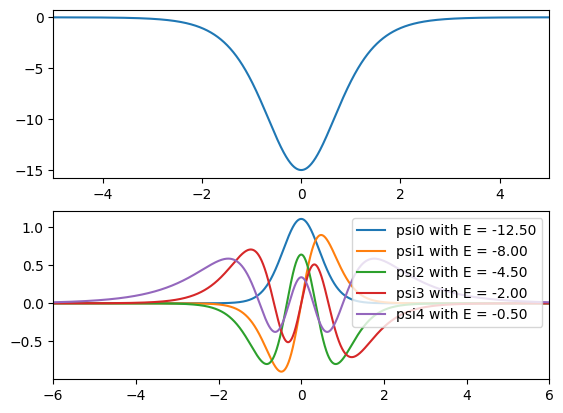

In [271]:
V_plot = symmetric(V, gerade=True)
xg = symmetric(xg, gerade=False)

fig, axs = plt.subplots(2, 1, sharex=False)

axs[0].plot(xg, V_plot)

for i,orb in enumerate(ao):
    axs[1].plot(xg, orb[0], label=f"psi{i} with E = {orb[1]:.2f}")

axs[0].set_xlim((-5, 5))
axs[1].set_xlim((-6, 6))

plt.legend(loc='upper right')

## LCAO for multiple potential wells
- set up potential in space
- set up basis functions in space (2D array, one dimension is the index of ao, the other is the function values)
- calculate H in ao basis
- calculate S in ao basis

set up potential


In [ ]:
d = 2
N_single = 40000
n_centers = 100
x_max = n_centers * d * 1.5
x_space = np.linspace(0, x_max, N_single)

def multiwell_pot(pot_funct, n_centers, d, x):
    V_tot = np.zeros((N_single))
    for i in range(n_centers):
        V_tot += pot_funct(x - (i+1)*d)
    return V_tot


pot = multiwell_pot(poeschl_teller, n_centers, d, x_space)

set up basis functions

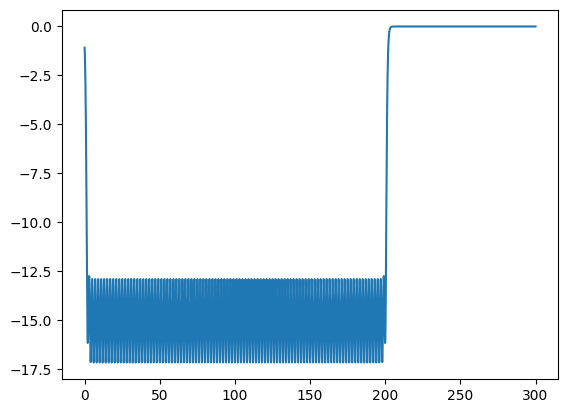

In [309]:
def move_center(psi, d, x, xg=xg):
    xg = xg + d
    spline = UnivariateSpline(xg, psi, s=0)
    psi_shift = spline(x)
    return psi_shift


n_states = 3  # number of atomic states used for every center
n_basis = n_states * n_centers

phi_ao = np.zeros((n_states, n_centers, np.shape(x_space)[0]))

for i in range(n_states):
    psi = ao[i][0]
    for j in range(n_centers):
        phi_ao[i,j] = move_center(psi, (j+1)*d, x_space)

phi_ao = np.reshape(phi_ao, (n_basis, np.shape(x_space)[0]))
        
plt.plot(x_space, pot)

calculate S matrix

In [310]:
def inner_prod(psi1, psi2, x_space):
    h = x_space[1]- x_space[0]
    return np.trapezoid(psi1 * psi2, dx=h)

def calc_S(phi_ao, x_space):
    n_basis = np.shape(phi_ao)[0]
    S = np.zeros((n_basis, n_basis))

    for j in range(n_basis):
        for i in range(n_basis): 
            S[i,j] = inner_prod(phi_ao[i], phi_ao[j], x_space)
    return S


Calculate H matrix

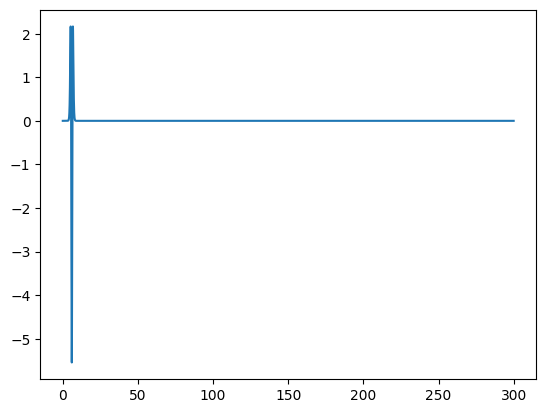

In [311]:
# why are there nonzero values at the boundaries?
def grid_laplacian(wf, x_space):
    h = x_space[1] - x_space[0]
    laplacian = np.zeros(np.shape(wf))
    wf = np.pad(wf, pad_width=1, mode="constant", constant_values=0)
    laplacian = (wf[:-2] + wf[2:] - 2 * wf[1:-1])/h**2
    return laplacian
      
def apply_hamiltonian(pot, phi, x_space):
    H = -0.5 * grid_laplacian(phi, x_space) + (pot * phi)
    return H

def calc_H(pot, phi_ao, x_space):
    n_basis = np.shape(phi_ao)[0]
    H = np.zeros((n_basis, n_basis))

    for j in range(n_basis):
        for i in range(n_basis): 
            ket = apply_hamiltonian(pot, phi_ao[j], x_space)
            H[i,j] = inner_prod(phi_ao[i], ket, x_space)
    return H

plt.plot(x_space, grid_laplacian(phi_ao[2], x_space))

Solve generalized eigenvalue problem

In [312]:
H = calc_H(pot, phi_ao, x_space)
S = calc_S(phi_ao, x_space)

E, c_vec = eig(H, S)
E = np.real(E)
print(np.shape(c_vec))
print(S)

(300, 300)
[[9.99999777e-01 1.91183911e-02 5.03705694e-06 ... 6.20841897e-24
  6.43145002e-24 6.65975963e-24]
 [1.91183911e-02 1.00000000e+00 1.91183912e-02 ... 5.99204554e-24
  6.20991145e-24 6.43299541e-24]
 [5.03705694e-06 1.91183912e-02 1.00000000e+00 ... 5.77933600e-24
  5.99204561e-24 6.20991153e-24]
 ...
 [6.20841897e-24 5.99204554e-24 5.77933600e-24 ... 1.00000000e+00
  3.55822355e-01 1.46665561e-02]
 [6.43145002e-24 6.20991145e-24 5.99204561e-24 ... 3.55822355e-01
  1.00000000e+00 3.55822355e-01]
 [6.65975963e-24 6.43299541e-24 6.20991153e-24 ... 1.46665561e-02
  3.55822355e-01 1.00000000e+00]]


In [313]:
#dim 0 is MO
#dim 2 is grid
mol_orb = c_vec.T @ phi_ao
print(np.shape(mol_orb))
#mol_orb = mol_orb.sum(axis=1)

orb = c_vec[0]
testorb = orb[:,np.newaxis] * phi_ao

(300, 40000)


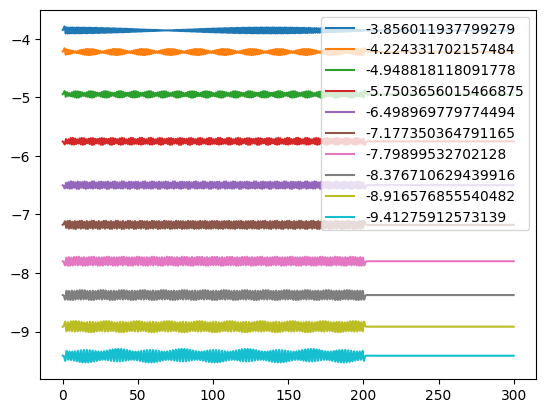

In [315]:
show_orb = range(1, 100, 10)
for i in show_orb:
    plt.plot(x_space, mol_orb[i] + E[i], label=f"{E[i]}")
plt.legend()